In [17]:
from datetime import datetime
from joblib import dump, load
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, SVC
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import pytz
import seaborn as sns
import statsmodels.api as sm
import ta
%matplotlib inline
p = "PuRd"
plt.style.use('default')

In [18]:
# Import the Data
btc = pd.read_csv("btchistorical.csv", parse_dates=["date"])
btc.columns = [c.replace(' ', '_') for c in btc.columns]
btc["MCAP"] = np.log(btc.market_cap)
btc["PRC"] = np.log(btc.close)
btc["MAXDPRC"] = btc.close.rolling(7).apply(lambda x: np.max(x))
# Momentum
for i in range(1,5):
    btc[f"r_{i},0"] = btc.close.rolling(i*7).apply(lambda x: x.iloc[-1]-x.iloc[0])
# TODO Past one-to-four-week return
#btc["r_4,1"] = np.NAN
# ?same value for all datapoints. Should this be done using a rolling mehtod?
btc["PRCVOL"] = list(map(lambda x: np.log(np.average(x.volume)) * x.close.iloc[0], btc.rolling(7)))
btc["STDPRCVOL"] = np.log(np.std(btc.PRCVOL))
btc["DAMIHUD"] = btc.close.rolling(2).apply(lambda x: np.abs((x.iloc[-1]-x.iloc[0])/(x.iloc[0])))
# Create 7 day return
#! Dayly Returns here
days = 7
btc["R7"] = btc.close.rolling(window=days).apply(lambda x: (x.iloc[-1]-x.iloc[0])/(x.iloc[0]))
# ? Shift correct here
btc.R7= btc.R7.shift(-days+1)

# More Predictors
btc['SMA_7'] = btc['close'].rolling(window=7).mean()  # Simple Moving Average
btc['SMA_21'] = btc['close'].rolling(window=21).mean()
btc['SMA_50'] = btc['close'].rolling(window=50).mean()
btc['STD_7'] = btc['close'].rolling(window=7).std()   # Standard Deviation
btc['STD_21'] = btc['close'].rolling(window=21).std()
btc['STD_50'] = btc['close'].rolling(window=50).std()
btc['RSI'] = ta.momentum.RSIIndicator(btc['close'], window=14).rsi()
btc['MACD'] = ta.trend.MACD(btc['close']).macd()

# Create lag features
for i in range(1, 8):
    btc['Close_Lag_'+str(i)] = btc['close'].shift(i)
    btc['Volume_Lag_'+str(i)] = btc['volume'].shift(i)
    btc['SMA_7_Lag_'+str(i)] = btc['SMA_7'].shift(i)
    btc['SMA_21_Lag_'+str(i)] = btc['SMA_21'].shift(i)
    btc['SMA_50_Lag_'+str(i)] = btc['SMA_50'].shift(i)
    btc['STD_7_Lag_'+str(i)] = btc['STD_7'].shift(i)
    btc['STD_21_Lag_'+str(i)] = btc['STD_21'].shift(i)
    btc['STD_50_Lag_'+str(i)] = btc['STD_50'].shift(i)
    btc['RSI_Lag_'+str(i)] = btc['RSI'].shift(i)
    btc['MACD_Lag_'+str(i)] = btc['MACD'].shift(i)

btc = btc.dropna()

In [19]:
# Training Data
Train = btc.loc[btc.date <= datetime(2021, 5, 1,0,0,0,0, pytz.UTC),]
Test = btc.loc[btc.date > datetime(2021, 5, 1,0,0,0,0, pytz.UTC),]
# ! different Time Zones
Test = Test.loc[Test.date <= datetime(2022, 5, 2,0,0,0,0, pytz.UTC),]

In [20]:
# Define features and target variable
X = Train.drop('R7', axis=1).drop('date', axis=1)
y = Train.R7
X_test = Test.drop('R7', axis=1).drop('date', axis=1)
y_test = Test.R7

In [21]:
# Random Forest
# Define target variable and features
y_train_rf = pd.Series(y > 0, dtype=int)
X_train_rf = X

# Create Random Forest Classifier model
rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])


# Define hyperparameters to search over
param_grid = {
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [5, 10, 15, 20],
    'rf__min_samples_split': [2, 4, 6],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to find best hyperparameters
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)

# Create Random Forest Classifier model with best hyperparameters
grid_search.fit(X=X_train_rf, y=y_train_rf)


Fitting 10 folds for each of 144 candidates, totalling 1440 fits
[CV] END rf__max_depth=5, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=5, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=5, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50; total time=   0.7s
[CV] END rf__max_depth=5, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50; total time=   0.7s
[CV] END rf__max_depth=5, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50; total time=   0.7s
[CV] END rf__max_depth=5, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50; total time=   0.7s
[CV] END rf__max_depth=5, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50; total time=   0.7s
[CV] END rf__max_depth=5, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50; total time=   0.6s
[CV] END rf__ma

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [5, 10, 15, 20],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 4, 6],
                         'rf__n_estimators': [50, 100, 150, 200]},
             verbose=2)

In [22]:
preds_rf = grid_search.predict(X_test)
r2_score(y_true=[t>0 for t in y_test], y_pred=preds_rf)

-0.9950283027344333

In [27]:
from sklearn.preprocessing import MinMaxScaler
# SVM
svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

# Define the grid of hyperparameters to search over
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__degree': [2, 3, 4],
    'svc__gamma':['scale', 'auto']
}

# Perform grid search using 10-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=10, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_rf, y_train_rf)
# Evaluate the best model on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

In [24]:
preds_svm = grid_search.predict(X=X_test)
r2_score(y_true=[t>0 for t in y_test], y_pred=preds_svm)

-1.1046452424451165

In [25]:
def calc_ts(signals:list, name:str, verbose:bool=True):
    # Starting Capital
    m = 10_000
    coins = 0
    capital_ts = list()
    
    for i, signal in enumerate(signals):
        price = Test.iloc[i].close
        if signal and m:
            # Buy
            coins = m/price
            m = 0
            if verbose: print(f"[INFO] {name} Bought {coins} BTC at {price}")
        elif not signal and coins:
            # Sell
            m = coins * price
            if verbose: print(f"[INFO] {name} Sold {coins} BTC at {price}")
            coins = 0
        # Append current net worth
        capital_ts.append(m + coins*price)
    # Sell after last period
    if coins:
        price = Test.iloc[i].close
        m = coins * price
        if verbose: print(f"[INFO] {name} Sold {coins} BTC at {price}")
        coins = 0
    print(f"[INFO] {name}: Total Capital {m}")
    plt.plot(capital_ts, label=name)
    return capital_ts, m

[INFO] RF: Total Capital 7821.6264120331225
[INFO] SVM: Total Capital 7349.84764879454
[INFO] Buy & Hold: Total Capital 6521.899862259137


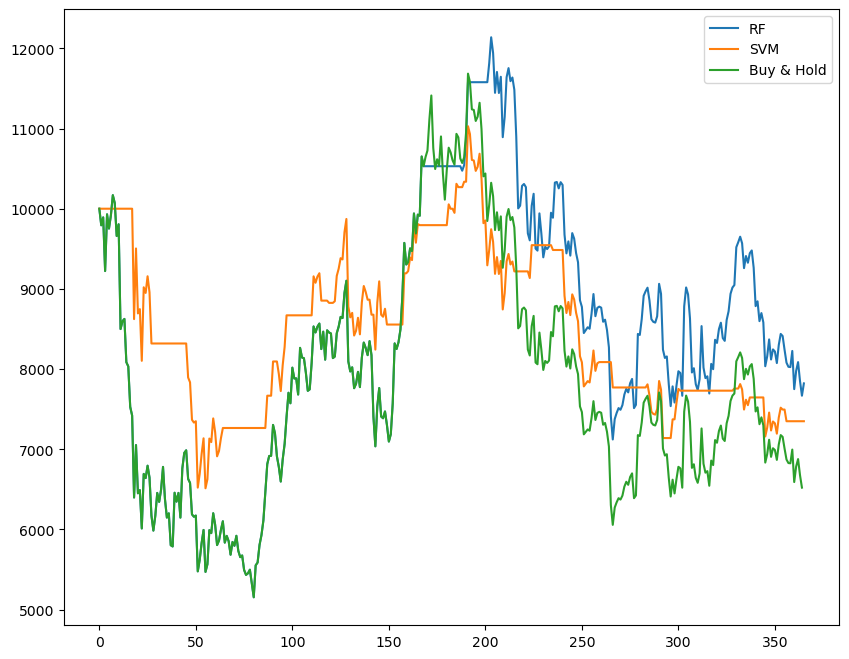

In [26]:
fig, ax = plt.subplots(figsize=(10, 8), nrows=1, ncols=1)

calc_ts(signals=preds_rf, name="RF", verbose=False)
calc_ts(signals=preds_svm, name="SVM", verbose=False)
calc_ts(signals=[True]*365, name="Buy & Hold", verbose=False)


plt.legend(prop={'size': 10})